In [1]:

from PIL import Image
import numpy as np
import glob
import regex 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve


In [2]:



def read_dataset(path):
  data= np.zeros([400,10305])
  i=0
  images_list = []
  for filename in glob.glob(path+"/*/*.pgm"): 
    im=Image.open(filename)
    images_list.append(im)
    l=regex.split(r'/', filename)
    l2= regex.split(r's', l[1])
    arr = np.array(im)
    data[i,0:10304]=arr.reshape(1,10304)
    data[i, -1]=l2[1]
    i+=1
  return data, images_list

    

In [3]:
def data_splitting(data):
    rows,cols=data.shape
    test_X = np.zeros([int(rows*0.5),cols-1])
    train_X = np.zeros([int(rows*0.5),cols-1])
    test_y= np.zeros(int(rows*0.5))
    train_y=np.zeros(int(rows*0.5))
    for i in range(data.shape[0]):
        if i%2 == 0:
            test_X[int(i/2)]=data[i,:-1]
            test_y[int(i/2)]= data[i,-1]
        else:
            train_X[int((i-1)/2)]=data[i,:-1]
            train_y[int((i-1)/2)]= data[i,-1] 
    return train_X, train_y, test_X, test_y


In [4]:
def data_splitting_70(data):
    rows,cols=data.shape
    test_X = np.zeros([int(rows*0.3),cols-1])
    train_X = np.zeros([int(rows*0.7),cols-1])
    test_y= np.zeros(int(rows*0.3))
    train_y=np.zeros(int(rows*0.7))
    x=0
    y=0
    for i in range(0,data.shape[0],10):
            test_X[x:x+3]=data[i:(i+3),:-1]
            test_y[x:x+3]= data[i:(i+3),-1]
            train_X[y:y+7]=data[(i+3):(i+10),:-1]
            train_y[y:y+7]= data[(i+3):(i+10),-1]
            x+=3
            y+=7
    return train_X, train_y, test_X, test_y



In [5]:
def visualize(images,i):
  plt.imshow(images[i])
  

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
## LDA
def get_classes(data):
    classes= []
    for i in range (41):
        indecies= np.argwhere(data[:,-1]== i)
        classes.append(data[indecies,:].reshape(len(indecies),data.shape[1]))      
    classes.pop(0)
    return classes

def centralized(classes,classes_Mean):
    z=[]
    for i, x in enumerate(classes):
        z.append(x - (np.ones(x.shape)*classes_Mean[i]))
    z=np.array(z)
    #Z=Z.reshape(400,10305)
    
    return z

def LDA(data):
    classes= get_classes(data)
    Means= np.mean(data,0)
    
    list = [np.mean(x, axis=0) for x in classes]
    classes_Mean= np.array(list)   
    print(classes_Mean.shape)
    
    SB=0
    for i, x in enumerate(classes):
        SB+=np.dot(x.shape[0]*(classes_Mean[i] - Means),(classes_Mean[1] - Means).T)

    ##..........center class matrices..........##
    Z= certerlaized(classes,classes_Mean) 
    
    ##..........Within class scatter matrix...........##
    s= []
    S_sum= np.zeros([Z.shape[1], Z.shape[1]])
    for i in range (len(classes)):
        s.append(Z[i].dot(Z[i].T))
        S_sum+=Z[i].dot(Z[i].T)
    print("number of classes=", len(s), "Summ_of S=", S_sum.shape)
    
    
    eigval, eigvec = np.linalg.eig(np.dot(np.linalg.inv(S_sum), SB))
    print(eigvec.shape)
    
LDA(data)



In [7]:
def KNN_classifer(X_train_transformed, y_train,preprocessor_type):

    #................................training........................................#    
    parameters = {'n_neighbors':[1,3,5,7]}
    KNN=KNeighborsClassifier()
    cv= KFold(n_splits=5,shuffle=True, random_state=5)
    KNN_opt = GridSearchCV(KNN, parameters,cv=cv,n_jobs=-1,return_train_score=True)
    KNN_opt.fit(X_train_transformed,  y_train)
    print("Best parameters:",KNN_opt.best_params_)
    print("Best score=",KNN_opt.best_score_ )
    mean_train_score=KNN_opt.cv_results_['mean_train_score']
    mean_test_score=KNN_opt.cv_results_['mean_test_score']
    param= KNN_opt.cv_results_['params']
    
    
    #..........................visualizing learning curves and tuning acuracies.......................#   
    title = "Learning Curves for best estimator using  "+ preprocessor_type
    plt=plot_learning_curve(KNN_opt, title, X_train_transformed,  y_train, cv=cv)
    plt.show()
    
    plt.plot(parameters['n_neighbors'], mean_test_score, 'ro')
    plt.show
    return mean_train_score, mean_test_score, parameters



Best parameters: {'n_neighbors': 1}
Best score= 0.91


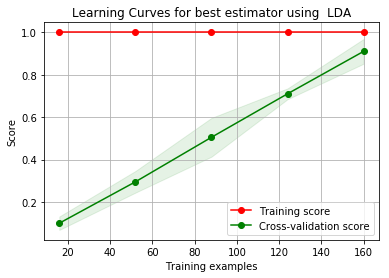

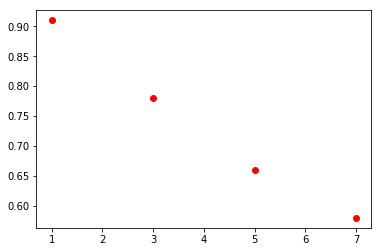

In [10]:
#def Main():
data, images= read_dataset("orl_faces") 
train_x, train_y, test_x, test_y= data_splitting(data)
train_70_X, train_70_y, test_70_X, test_70_y=data_splitting_70(data)

## PCA
#preprocessor_type= "PCA"
#mean_train_score, mean_test_score,parameters =KNN_classifer(train_x, train_y, preprocessor_type)


## LDA
preprocessor_type="LDA"
mean_train_score, mean_test_score,parameters =KNN_classifer(train_x, train_y,preprocessor_type)



In [39]:
def FOTV(eig_vals,totVar,alphas):
    I=dict()
    for alpha in alphas:
        expVar=0.0
        i=0
        while expVar <= (alpha * totVar): 
            expVar+=eig_vals[i]
            i+=1
        I[alpha]=i
    return I

In [40]:
def pCA(dataMatrix):
    transformed=dict()
    reducedVec=dict()
    X=dataMatrix[:,:]
    num_data, dim = X.shape
    mean_X = X.mean(axis=0)
    X = X - mean_X 
    cov_mat = np.dot(X.T, X)/(num_data) # covariance matrix
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    totVar = sum(eig_vals)
    idx = eig_vals.argsort()[::-1]   
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]
    num = FOTV(eig_vals,totVar,[0.8,0.85,0.9,0.95])
    for key, vals in num.items(): 
        reducedVec[key]=eig_vecs[:vals,:]
        transformed[key]=np.absolute(X.dot(reducedVec[key].T))
    return transformed,reducedVec

In [41]:
transformed,reducedVec=pCA(train_x)


In [42]:
transformed_70,reducedVec_70=pCA(train_70_X)

In [43]:
def kmodel_score(train_X,train_Y ,test_X,test_Y,neighbors):
    knn_model = KNeighborsClassifier(n_neighbors=neighbors)
    knn_model.fit(train_X, train_Y) 
    y_predict = knn_model.score(test_X,test_Y)
    return(y_predict)

In [44]:
info={}
for key, vals in transformed.items(): 
    test_X=np.absolute(test_x.dot(reducedVec[key].T))
    score=kmodel_score(vals, train_y, test_X, test_y,1)
    info[key]=score 
print(info)        

{0.8: 0.065, 0.85: 0.04, 0.9: 0.03, 0.95: 0.05}


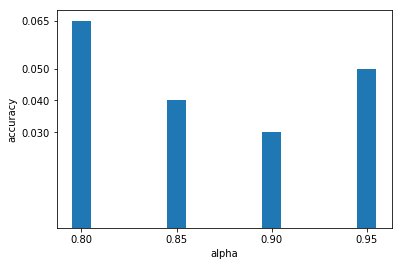

In [91]:
keys = list(info.keys())
vals = list(info.values())

plt.bar(keys,vals,align='center',width=0.01)
plt.ylabel ('accuracy')
plt.yticks(list(vals))
plt.xlabel ('alpha')
plt.xticks(list(keys))
plt.savefig('pcaAccuracy.png')
plt.show()


In [92]:
def pca_classification_70(transformed_70,reducedVec_70):    
    infoPCA={}
    for i in [1,3,5,7]:
        infoPCA[i]={}
        for key, vals in transformed_70.items(): 
            test_X=np.absolute(test_70_X.dot(reducedVec_70[key].T))
            score=kmodel_score(vals, train_70_y, test_X, test_70_y,i)
            infoPCA[i][key]=score 
    for i in infoPCA.keys():
        keys = list(infoPCA[i].keys())
        vals = list(infoPCA[i].values())
        plt.bar(keys,vals,align='center',width=0.01,label=i)
        plt.ylabel ('accuracy')
        plt.yticks(list(vals))
        plt.xlabel ('alpha')
        plt.xticks(list(keys))
        plt.legend(loc='upper right')
        plt.savefig('./figures/PCA/pcaAccuracy70_'+str(i)+'.png')
        plt.show()

In [94]:
def pca_classification(transformed,reducedVec):    
    infoPCA={}
    for i in [1,3,5,7]:
        infoPCA[i]={}
        for key, vals in transformed.items(): 
            test_X=np.absolute(test_x.dot(reducedVec[key].T))
            score=kmodel_score(vals, train_y, test_X, test_y,i)
            infoPCA[i][key]=score 
    for i in infoPCA.keys():
        keys = list(infoPCA[i].keys())
        vals = list(infoPCA[i].values())
        plt.bar(keys,vals,align='center',width=0.01,label=i)
        plt.ylabel ('accuracy')
        plt.yticks(list(vals))
        plt.xlabel ('alpha')
        plt.xticks(list(keys))
        plt.legend(loc='upper right')
        plt.savefig('./figures/PCA/pcaAccuracy'+str(i)+'.png')
        plt.show()

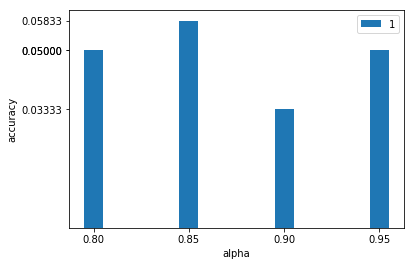

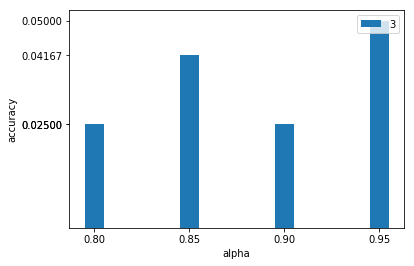

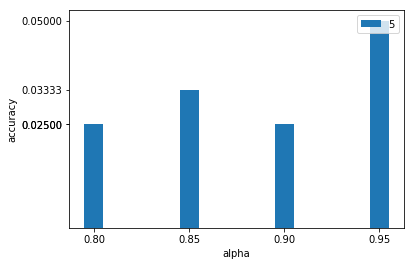

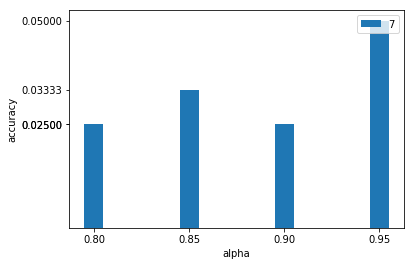

In [90]:
pca_classification_70(transformed_70,reducedVec_70)

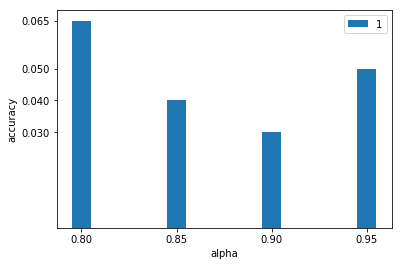

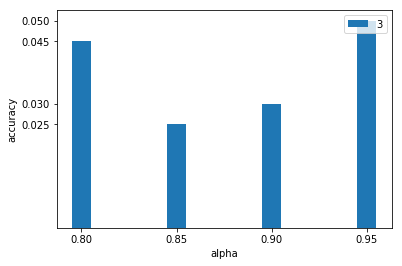

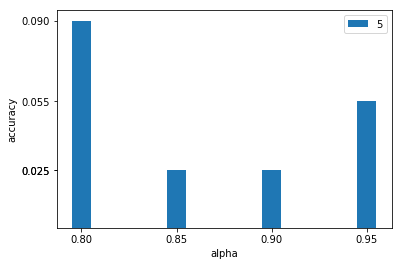

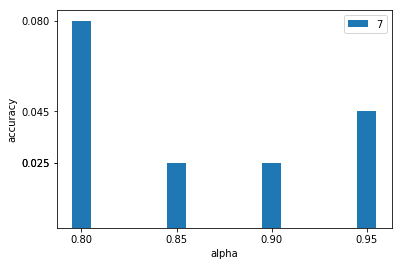

In [95]:
pca_classification(transformed,reducedVec)